# PeakVI: Analyzing scATACseq data

PeakVI is used for analyzing scATACseq data. This tutorial walks through how to read, set-up and train the model, accessing and visualizing the latent space, and differential accessibility. We use the 5kPBMC sample dataset from 10X but these steps can be easily adjusted for other datasets.

In [ ]:
!pip install --quiet scvi-colab
from scvi_colab import install

install()

In [1]:
import anndata
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scanpy as sc
import scipy
import scvi

     |████████████████████████████████| 72 kB 1.2 MB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
nbclient 0.5.11 requires jupyter-client>=6.1.5, but you have jupyter-client 5.3.5 which is incompatible.
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 713 kB 14.8 MB/s 
     |████████████████████████████████| 217 kB 71.0 MB/s 
     |████████████████████████████████| 91 kB 11.8 MB/s 
     |████████████████████████████████| 397 kB 76.8 MB/s 
     |████████████████████████████████| 527 kB 72.1 MB/s 
     |████████████████████████████████| 2.0 MB 66.4 MB/s 
     |████████████████████████████████| 8.8 MB 33.1 MB/s 
     |████████████████████████████████| 1.1 MB 57.5 MB/s 
     |████████████████████████████████| 1.4 MB 56.4 MB/s 
     |███████████

First we need to download the sample data. This block will do this for a google colab session, but if you're running it in a different platform you might need to adjust it, or download and unpack the data manually.

In [2]:
!wget https://cf.10xgenomics.com/samples/cell-atac/1.2.0/atac_pbmc_5k_nextgem/atac_pbmc_5k_nextgem_filtered_peak_bc_matrix.tar.gz
!tar -xvf atac_pbmc_5k_nextgem_filtered_peak_bc_matrix.tar.gz


--2022-02-28 04:36:25--  https://cf.10xgenomics.com/samples/cell-atac/1.2.0/atac_pbmc_5k_nextgem/atac_pbmc_5k_nextgem_filtered_peak_bc_matrix.tar.gz
Resolving cf.10xgenomics.com (cf.10xgenomics.com)... 104.18.0.173, 104.18.1.173, 2606:4700::6812:1ad, ...
Connecting to cf.10xgenomics.com (cf.10xgenomics.com)|104.18.0.173|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 114015463 (109M) [application/x-tar]
Saving to: ‘atac_pbmc_5k_nextgem_filtered_peak_bc_matrix.tar.gz’

atac_pbmc_5k_nextge 100%[===================>] 108.73M  26.4MB/s    in 5.1s    

2022-02-28 04:36:31 (21.2 MB/s) - ‘atac_pbmc_5k_nextgem_filtered_peak_bc_matrix.tar.gz’ saved [114015463/114015463]

filtered_peak_bc_matrix/
filtered_peak_bc_matrix/matrix.mtx
filtered_peak_bc_matrix/peaks.bed
filtered_peak_bc_matrix/barcodes.tsv


In [3]:
scvi.settings.seed = 420

sc.set_figure_params(figsize=(4, 4), frameon=False)

%config InlineBackend.print_figure_kwargs={'facecolor' : "w"}
%config InlineBackend.figure_format='retina'

Global seed set to 0
/usr/local/lib/python3.7/dist-packages/numba/np/ufunc/parallel.py:363: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 9107. The TBB threading layer is disabled.
  warnings.warn(problem)
Global seed set to 420


## loading data

PeakVI expects as input an AnnData object with a cell-by-region matrix. There are various pipelines that handle preprocessing of scATACseq to obtain this matrix from the sequencing data. If the data was generated by 10X genomics, this matrix is among the standard outputs of CellRanger. Other pipelines, like [SnapATAC](https://github.com/r3fang/SnapATAC/) and [ArchR](https://www.archrproject.com/bookdown/add-peak-matrix.html), also generate similar matrices.

In the case of 10X data, PeakVI has a special reader function `scvi.data.read_10x_atac` that reads the files and creates an AnnData object, demonstrated below. For conveniece, we also demonstrate how to initialize an AnnData object from scratch.

Throughout this tutorial, we use [sample scATACseq data from 10X of 5K PBMCs](https://support.10xgenomics.com/single-cell-atac/datasets/1.2.0/atac_pbmc_5k_nextgem).

In [4]:
# read the count matrix into a sparse matrix, and the cell and region annotations as pandas DataFrames
counts = scipy.io.mmread("filtered_peak_bc_matrix/matrix.mtx").T
regions = pd.read_csv(
    "filtered_peak_bc_matrix/peaks.bed",
    sep="\t",
    header=None,
    names=["chr", "start", "end"],
)
cells = pd.read_csv(
    "filtered_peak_bc_matrix/barcodes.tsv", header=None, names=["barcodes"]
)

# then initialize a new AnnData object
adata = anndata.AnnData(X=counts, obs=cells, var=regions)

# or use this methods to read 10x data directly
adata = scvi.data.read_10x_atac("filtered_peak_bc_matrix")

/usr/local/lib/python3.7/dist-packages/anndata/_core/anndata.py:120: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


we can use scanpy functions to handle, filter, and manipulate the data. In our case, we might want to filter out peaks that are rarely detected, to make the model train faster:

In [5]:
print(adata.shape)
# compute the threshold: 5% of the cells
min_cells = int(adata.shape[0] * 0.05)
# in-place filtering of regions
sc.pp.filter_genes(adata, min_cells=min_cells)
print(adata.shape)

(4585, 115554)
(4585, 33142)


## set up, training, saving, and loading

We can now set up the AnnData object, which will ensure everything the model needs is in place for training.

This is also the stage where we can condition the model on additional covariates, which encourages the model to remove the impact of those covariates from the learned latent space. Our sample data is a single batch, so we won't demonstrate this directly, but it can be done simply by setting the `batch_key` argument to the annotation to be used as a batch covariate (must be a valid key in `adata.obs`) .

In [6]:
scvi.model.PEAKVI.setup_anndata(adata)

We can now create a PeakVI model object and train it!

**Importantly**: the default max epochs is set to 500, but in practice PeakVI stops early once the model converges, which rarely requires that many, especially for large datasets (which require fewer epochs to converge, since each epoch includes letting the model view more data).
*So the estimated runtime is usually a substantial overestimate of the actual runtime.*
In the case of the data we use for this tutorial, it used less than half of the max epochs!

In [7]:
pvi = scvi.model.PEAKVI(adata)
pvi.train()

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 299/500:  60%|█████▉    | 299/500 [05:12<03:29,  1.04s/it, loss=1.93e+08, v_num=1]
Monitored metric reconstruction_loss_validation did not improve in the last 50 records. Best score: 12754.396. Signaling Trainer to stop.


since training a model can take a while, we recommend saving the trained model after training, just in case.

In [8]:
pvi.save("trained_model", overwrite=True)

We can then load the model later, which require providing an AnnData object that is structured similarly to the one used for training (or, in most cases, the same one):

In [10]:
pvi = scvi.model.PEAKVI.load("trained_model", adata=adata)

## visualizing and analyzing the latent space

We can now use the trained model to visualize, cluster, and analyze the data. We first extract the latent representation from the model, and save it back into our AnnData object:

In [11]:
latent = pvi.get_latent_representation()
adata.obsm["X_PeakVI"] = latent

print(latent.shape)

(4585, 13)


We can now use scanpy functions to cluster and visualize our latent space:

In [13]:
# compute the k-nearest-neighbor graph that is used in both clustering and umap algorithms
sc.pp.neighbors(adata, use_rep="X_PeakVI")
# compute the umap
sc.tl.umap(adata, min_dist=0.2)
# cluster the space (we use a lower resolution to get fewer clusters than the default)
sc.tl.leiden(adata, key_added="cluster_pvi", resolution=0.2)

/usr/local/lib/python3.7/dist-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'chr' as categorical


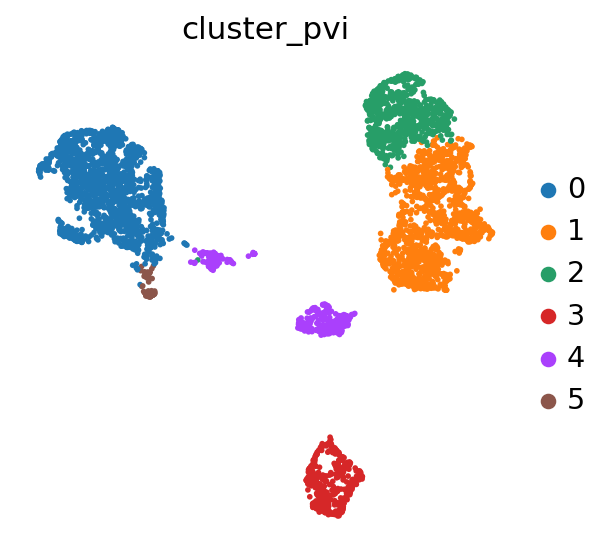

In [14]:
sc.pl.umap(adata, color="cluster_pvi")

## differential accessibility

Finally, we can use PeakVI to identify regions that are differentially accessible. There are many different ways to run this analysis, but the simplest is comparing one cluster against all others, or comparing two clusters to each other. In the first case we'll be looking for marker-regions, so we'll mostly want a one-sided test (the significant regions will only be the ones preferentially accessible in our target cluster). In the second case we'll use a two-sided test to find regions that are differentially accessible, regardless of direction.

We demonstrate both of these next, and do this in two different ways: (1) more convenient but less flexible: using an existing factor to group the cells, and then comparing groups. (2) more flexible: using cell indices directly.

:::\{important}
If the data includes multiple batches, we encourage setting `batch_correction=True` so the model will sample from multiple batches when computing the differential signal. We do this below despite the data only having a single batch, as a demonstration.
:::

In [15]:
# (1.1) using a known factor to compare two clusters
## two-sided is True by default, but included here for emphasis
da_res11 = pvi.differential_accessibility(
    groupby="cluster_pvi", group1="3", group2="0", two_sided=True
)

# (1.2) using a known factor to compare a cluster against all other clusters
## if we only provide group1, group2 is all other cells by default
da_res12 = pvi.differential_accessibility(
    groupby="cluster_pvi", group1="3", two_sided=False
)

# (2.1) using indices to compare two clusters
## we can use boolean masks or integer indices for the `idx1` and `idx2` arguments
da_res21 = pvi.differential_accessibility(
    idx1=adata.obs.cluster_pvi == "3",
    idx2=adata.obs.cluster_pvi == "0",
    two_sided=True,
)
# (2.2) using indices to compare a cluster against all other clusters
## if we don't provide idx2, it uses all other cells as the contrast
da_res22 = pvi.differential_accessibility(
    idx1=np.where(adata.obs.cluster_pvi == "3"),
    two_sided=False,
)

da_res22.head()

DE...: 100%|██████████| 1/1 [00:10<00:00, 10.87s/it]


,prob_da,is_da_fdr,bayes_factor,effect_size,emp_effect,est_prob1,est_prob2,emp_prob1,emp_prob2
chr11:45951188-45953584,1.0,True,18.420681,-0.727015,-0.400252,0.905678,0.178663,0.496629,0.096377
chr4:115519248-115520882,1.0,True,18.420681,-0.722754,-0.389592,0.756693,0.033939,0.406742,0.017150
chr3:13151900-13153013,1.0,True,18.420681,-0.873769,-0.480087,0.924364,0.050595,0.507865,0.027778
chr2:47951226-47952150,1.0,True,18.420681,-0.837306,-0.439850,0.862172,0.024866,0.451685,0.011836
chr11:60222766-60223569,1.0,True,18.420681,-0.884811,-0.512484,0.905579,0.020768,0.523596,0.011111


Note that `da_res11` and `da_res21` are equivalent, as are `da_res12` and `da_res22`.
The return value is a pandas DataFrame with the differential results and basic properties of the comparison:

`prob_da` in our case is the probability of cells from cluster 0 being more than 0.05 (the default minimal effect) more accessible than cells from the rest of the data.

`is_da_fdr` is a conservative classification (True/False) of whether a region is differential accessible. This is one way to threshold the results.

`bayes_factor` is a statistical significance score. It doesn't have a commonly acceptable threshold (e.g 0.05 for p-values), bu we demonstrate below that it's well calibrated to the effect size.

`effect_size` is the effect size, calculated as `est_prob1 - est_prob2`.

`emp_effect` is the empirical effect size, calculated as `emp_prob1 - emp_prob2`.

`est_prob{1,2}` are the estimated probabilities of accessibility in group1 and group2.

`emp_prob{1,2}` are the empirical probabilities of detection (how many cells in group X was the region detected in).

We can make sure the probability of DA is well calibrated, and look at the regions that are identified as differentially accessible:

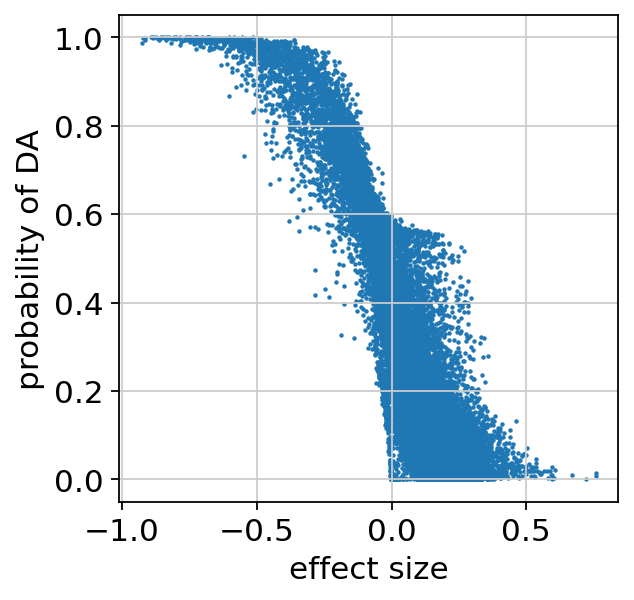

,prob_da,is_da_fdr,bayes_factor,effect_size,emp_effect,est_prob1,est_prob2,emp_prob1,emp_prob2
chr11:45951188-45953584,1.0000,True,18.420681,-0.727015,-0.400252,0.905678,0.178663,0.496629,0.096377
chr2:47951226-47952150,1.0000,True,18.420681,-0.837306,-0.439850,0.862172,0.024866,0.451685,0.011836
chr11:60222766-60223569,1.0000,True,18.420681,-0.884811,-0.512484,0.905579,0.020768,0.523596,0.011111
chr4:115519248-115520882,1.0000,True,18.420681,-0.722754,-0.389592,0.756693,0.033939,0.406742,0.017150
chr3:13151900-13153013,1.0000,True,18.420681,-0.873769,-0.480087,0.924364,0.050595,0.507865,0.027778
chr10:126289468-126291985,0.9998,True,8.516943,-0.892011,-0.477137,0.932383,0.040372,0.498876,0.021739
chr22:22776937-22777587,0.9998,True,8.516943,-0.686266,-0.349940,0.727352,0.041086,0.368539,0.018599
chr9:37408865-37409992,0.9998,True,8.516943,-0.854023,-0.500657,0.941401,0.087378,0.546067,0.045411
chr22:22522044-22523273,0.9998,True,8.516943,-0.762959,-0.404079,0.868831,0.105872,0.458427,0.054348
chr15:59704741-59706175,0.9998,True,8.516943,-0.808251,-0.401216,0.850416,0.042165,0.422472,0.021256


In [16]:
plt.scatter(da_res22.effect_size, da_res22.prob_da, s=1)
plt.xlabel("effect size")
plt.ylabel("probability of DA")
plt.show()

da_res22.loc[da_res22.is_da_fdr].sort_values("prob_da", ascending=False).head(10)

We can now examine these regions to understand what is happening in the data, using various different annotation and enrichment methods. For instance, `chr11:60222766-60223569`, one of the regions preferentially accessible in cluster 0, is the promoter region of [`MS4A1`](https://www.genecards.org/cgi-bin/carddisp.pl?gene=MS4A1), also known as `CD20`, a known B-cell surface marker, indicating that cluster 0 are probably B-cells.